# Handwritten Digits Prediction

<p align="center">
<img src="img/digits.gif">
</p>

The MNIST database contains binary images of **handwritten digits**. The original black and white images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. The images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.The database has a training set of 60,000 examples, and a test set of 10,000 examples. There are 10 classes (one for each of the 10 digits).

## 0.0. Imports

In [1]:
import pandas as pd
import numpy  as np

import scikitplot        as skplt
import matplotlib.pyplot as plt

from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics         import accuracy_score
from sklearn.neural_network  import MLPClassifier
from sklearn.svm             import SVC

from mnist import MNIST

import random
import warnings
warnings.filterwarnings( "ignore" )

## 0.1. Helper Functions

In [11]:
# Support Vector Machine with 
def rbf_model( X_train, X_test, y_train, y_test, cv, MAX_EVAL, param ):
    
    final_result = {
        'Regularization': [],
        'Gamma': [],
        'Tol': [],
        'Max_iter': [],
        'Hold_out': [],
        'Cross_validation': []
    }
    
    for i in range( MAX_EVAL ):
        print('\n\nMODELO ', i + 1)
        
        # choose values for parameters randomly
        hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
        print('Parâmetros: ', hp)
        final_result['Regularization'].append(hp['C'])
        final_result['Gamma'].append(hp['gamma'])
        final_result['Tol'].append(hp['tol'])
        final_result['Max_iter'].append(hp['max_iter'])
        
        # model
        model_rbf = SVC( C = hp['C'],
                         gamma = hp['gamma'],
                         tol = hp['tol'],
                         max_iter = hp['max_iter'],
                         random_state = 33)
        
        # fit and training
        y_pred = model_rbf.fit( X_train, y_train ).predict( X_test )
        
        # performance - hold-out
        result = accuracy_score( y_test, y_pred )
        confusion_matrix( y_test, y_pred )
        
        # performance - cross validation
        result_cv = cross_val_score( model_rbf, X_train, y_train, cv=cv )
        print( 'Performance média: ', np.mean( result_cv ) )
        print( 'Desvio padrão: ', np.std( result_cv ) )
        
        final_result['Hold_out'].append( format( result, ".2f" ))
        final_result['Cross_validation'].append( format( np.mean( result_cv ), ".2f" ) )
        
    print( pd.DataFrame( final_result ) )
    
    return None

# Multilayer Perceptron
def mlp_model( X_train, X_test, y_train, y_test, cv, MAX_EVAL, param ):
    
    final_result = {
        'Hidden_layer_sizes': [],
        'Activation': [],
        'Solver': [],
        'Hold_out': [],
        'Cross_validation': []
    }
    
    for i in range( MAX_EVAL ):
        
        print('\n\nMODELO ', i + 1)
        
        # choose values for parameters randomly
        hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
        print('Parâmetros: ', hp)
        final_result['Hidden_layer_sizes'].append(hp['hls'])
        final_result['Activation'].append(hp['activation'])
        final_result['Solver'].append(hp['solver'])
        
        # model
        model_mlp = MLPClassifier( hidden_layer_sizes = hp['hls'],
                                   activation = hp['activation'],
                                   solver = hp['solver'],
                                   random_state = 33 )
        
        # fit and training
        y_pred = model_mlp.fit( X_train, y_train ).predict( X_test )
        
        # performance - hold-out
        result = accuracy_score( y_test, y_pred )
        confusion_matrix( y_test, y_pred )
        
        # performance - cross validation
        result_cv = cross_val_score( model_mlp, X_train, y_train, cv=cv )
        print( 'Performance média: ', np.mean( result_cv ) )
        print( 'Desvio padrão: ', np.std( result_cv ) )
        
        final_result['Hold_out'].append( format( result, ".2f" ) )
        final_result['Cross_validation'].append( format ( np.mean( result_cv ), ".2f" ) )
        
    print( pd.DataFrame( final_result ) )
    
    return None
        
    

# Plot confusion matrix
def confusion_matrix( y, predictions ):
    skplt.metrics.plot_confusion_matrix( y, predictions )
    plt.figure( figsize=(12, 8) )
    plt.show()
    
    return None

## 0.2. Loading Data

In [3]:
# Load data
mndata = MNIST( 'datasets/images_handwritten_digits' )

image_train, label_train = mndata.load_training( )
image_test, label_test = mndata.load_testing( )

In [4]:
# View an image
index = random.randrange( 0, len( image_train ) ) 
print( mndata.display( image_train[index] ) )


............................
............................
............................
............................
............................
....................@@......
................@@@@@@......
..........@@@@@@@@@@@@......
.........@@@@@@@...@@@......
........@@@@@@.....@@.......
........@@@........@@.......
..................@@........
.................@@.........
................@@@.........
..............@@@@@.........
..............@@@@@@@.......
...................@@.......
....................@.......
....................@.......
...@@@.............@@.......
..@@@.............@@@.......
..@@.............@@@........
...@@.........@@@@..........
....@@@@@@@@@@@.............
............................
............................
............................
............................


In [5]:
# Data transformation
image_train = pd.DataFrame( image_train )
image_test = pd.DataFrame( image_test )
label_train = pd.DataFrame( label_train )
label_test = pd.DataFrame( label_test )

In [6]:
# Joining image Dataframes
X = pd.concat( [image_train, image_test], ignore_index=True )

# Joining target Dataframes
y = pd.concat( [label_train, label_test], ignore_index=True )

## 1.0. Data Description

In [8]:
# Data dimensions
print('Número de linhas: ', X.shape[0])
print('Número de colunas: ', X.shape[1])

Número de linhas:  70000
Número de colunas:  784


In [12]:
# Data types
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, 0 to 783
dtypes: int64(784)
memory usage: 418.7 MB


In [20]:
# checking missing values
X.isnull().sum().sort_values(ascending=False)

783    0
268    0
266    0
265    0
264    0
      ..
520    0
519    0
518    0
517    0
0      0
Length: 784, dtype: int64

## 2.0. Data Preparation

In [7]:
# Normalization
X = pd.DataFrame( MinMaxScaler().fit_transform( X ) )

## 3.0. Split dataframe into training and test dataset

In [8]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=1 )

## 4.0. Machine Learning Modelling

### 4.1. RBF

In [18]:
# Parameters and number of iterations
param = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'tol': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [-1, 200, 500, 1000]
}

MAX_EVAL = 3

#### 4.1.1. k = 5 for cross validation



MODELO  1
Parâmetros:  {'C': 100, 'gamma': 0.01, 'tol': 0.001, 'max_iter': 1000}


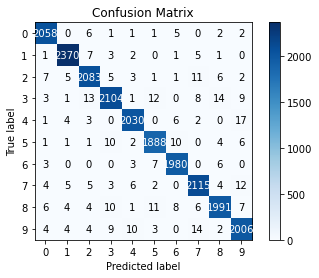

<Figure size 864x576 with 0 Axes>

Performance média:  0.9792448979591836
Desvio padrão:  0.0009476070829586999


MODELO  2
Parâmetros:  {'C': 0.1, 'gamma': 0.001, 'tol': 0.01, 'max_iter': 200}


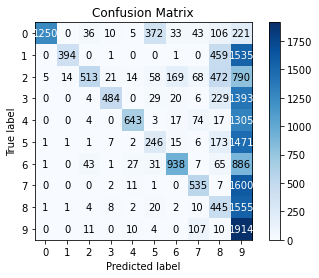

<Figure size 864x576 with 0 Axes>

Performance média:  0.38630612244897955
Desvio padrão:  0.02794796438090321


MODELO  3
Parâmetros:  {'C': 1, 'gamma': 1, 'tol': 0.001, 'max_iter': -1}


In [ ]:
rbf_model( X_train, X_test, y_train, y_test, 5, MAX_EVAL, param )

#### 4.1.2. k = 10 for cross validation



MODELO  1
Parâmetros:  {'C': 10, 'gamma': 0.01, 'tol': 0.01, 'max_iter': 500}


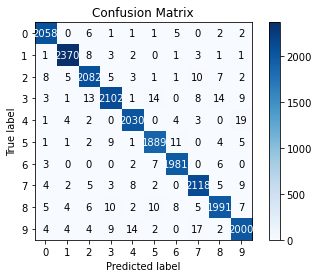

<Figure size 864x576 with 0 Axes>

Performance média:  0.9802857142857142
Desvio padrão:  0.002444213048421216


MODELO  2
Parâmetros:  {'C': 100, 'gamma': 0.01, 'tol': 0.01, 'max_iter': 1000}


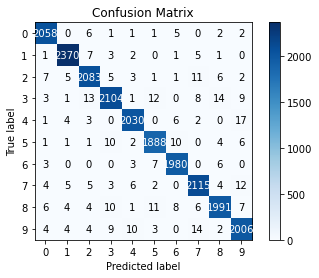

<Figure size 864x576 with 0 Axes>

Performance média:  0.980387755102041
Desvio padrão:  0.0019774867831440653


MODELO  3
Parâmetros:  {'C': 100, 'gamma': 1, 'tol': 0.001, 'max_iter': 200}


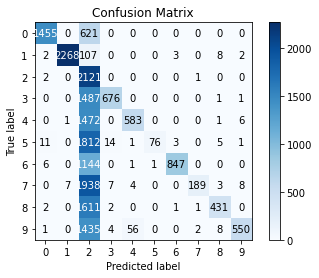

<Figure size 864x576 with 0 Axes>

Performance média:  0.43630612244897965
Desvio padrão:  0.028785994616262266
   Regularization  Gamma    Tol  Max_iter Hold_out Cross_validation
0              10   0.01  0.010       500     0.98             0.98
1             100   0.01  0.010      1000     0.98             0.98
2             100   1.00  0.001       200     0.44             0.44


In [19]:
rbf_model( X_train, X_test, y_train, y_test, 10, MAX_EVAL, param )

### 4.2. MLP

In [14]:
# Parameters and number of iterations
param = {
    'hls': [(50,), (100,), (100, 50,), (150, 100,)],
    'activation': ['logistic', 'relu', 'tanh', 'identity'],
    'solver': ['sgd', 'lbfgs', 'adam'],
}

MAX_EVAL = 3

#### 4.2.1. k = 5 for cross validation



MODELO  1
Parâmetros:  {'hls': (100,), 'activation': 'relu', 'solver': 'sgd'}


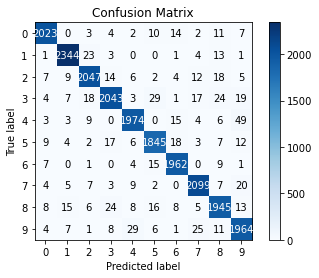

<Figure size 864x576 with 0 Axes>

Performance média:  0.9619591836734693
Desvio padrão:  0.001800550612254122


MODELO  2
Parâmetros:  {'hls': (50,), 'activation': 'tanh', 'solver': 'adam'}


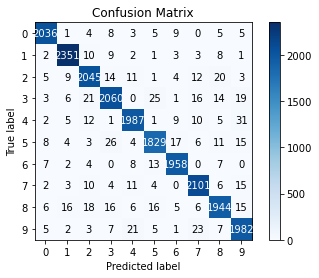

<Figure size 864x576 with 0 Axes>

Performance média:  0.9644897959183674
Desvio padrão:  0.0017232515781701368


MODELO  3
Parâmetros:  {'hls': (50,), 'activation': 'logistic', 'solver': 'sgd'}


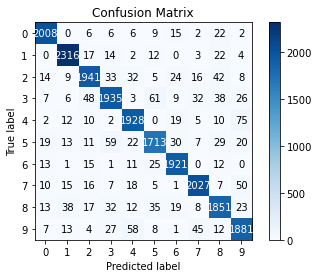

<Figure size 864x576 with 0 Axes>

Performance média:  0.9243673469387754
Desvio padrão:  0.0024382417655191514
  Hidden_layer_sizes Activation Solver Hold_out Cross_validation
0             (100,)       relu    sgd     0.96             0.96
1              (50,)       tanh   adam     0.97             0.96
2              (50,)   logistic    sgd     0.93             0.92


In [15]:
mlp_model( X_train, X_test, y_train, y_test, 5, MAX_EVAL, param )

#### 4.2.2. k = 10 for cross validation



MODELO  1
Parâmetros:  {'hls': (100,), 'activation': 'identity', 'solver': 'adam'}


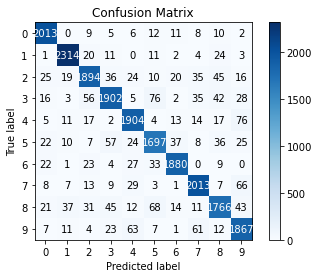

<Figure size 864x576 with 0 Axes>

Performance média:  0.9152857142857144
Desvio padrão:  0.002476797787527256


MODELO  2
Parâmetros:  {'hls': (100,), 'activation': 'relu', 'solver': 'sgd'}


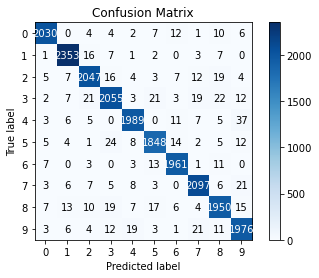

<Figure size 864x576 with 0 Axes>

Performance média:  0.9638775510204083
Desvio padrão:  0.0034861539654831397


MODELO  3
Parâmetros:  {'hls': (100,), 'activation': 'relu', 'solver': 'sgd'}


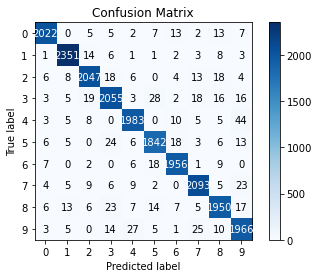

<Figure size 864x576 with 0 Axes>

Performance média:  0.9643061224489797
Desvio padrão:  0.0028373219183715423
  Hidden_layer_sizes Activation Solver Hold_out Cross_validation
0             (100,)   identity   adam     0.92             0.92
1             (100,)       relu    sgd     0.97             0.96
2             (100,)       relu    sgd     0.96             0.96


In [16]:
mlp_model( X_train, X_test, y_train, y_test, 10, MAX_EVAL, param )

## 5.0. Majority Error

In [ ]:
y = pd.DataFrame(y)

errors = ( y[0].value_counts() / y.shape[0] ).sort_values( ascending=False )

errors

In [ ]:
1 - errors[0]